---
title: Upsampled Example MoS2
authors: [gvarnavides]
date: 2025-06-14
---

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import ipywidgets

plt.rcParams['text.color']='white'

In [2]:

def estimate_scalebar_length(length: float, sampling: float):
    """Estimate an appropriate scale bar length based on data dimensions.

    This function calculates a "nice" scale bar length that is a multiple of
    0.5, 1.0, or 2.0 times a power of 10, depending on the data range.

    Parameters
    ----------
    length : float
        Total length of the data in physical units.
    sampling : float
        Physical units per pixel.

    Returns
    -------
    tuple
        (length_units, length_pixels) where length_units is the estimated
        scale bar length in physical units and length_pixels is the equivalent
        in pixels.
    """
    d = length * sampling / 2
    exp = np.floor(np.log10(d))
    base = d / (10**exp)
    if base >= 1 and base < 2.1:
        spacing = 0.5
    elif base >= 2.1 and base < 4.6:
        spacing = 1.0
    elif base >= 4.6 and base <= 10:
        spacing = 2.0
    else:
        spacing = 1.0  # default case
    spacing = spacing * 10**exp
    return spacing, spacing / sampling

In [3]:
def add_individual_reveal_sliders(
    fig, axes, image_pairs, titles=None, pixelsizes = None, init=0.0,
    cmap='gray', vmin_vmax='auto',
):
    """
    Add individual reveal sliders for each axes and image pair.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        The figure containing the axes.
    axes : list of Axes
        List of axes (length N).
    image_pairs : list of (img1, img2)
        List of (raw, processed) image pairs, one for each axis.
    init : float
        Initial slider position (between 0 and 1).
    cmap : str
        Colormap for imshow.
    vmin_vmax : 'auto' or list of (vmin1, vmax1, vmin2, vmax2)
        If 'auto', compute contrast limits from quantiles.
    slider_height : float
        Height of each slider as fraction of figure height.
    slider_offset : float
        Vertical offset below each axes for slider placement.
    """
    sliders = []

    for i, (ax, (img1, img2)) in enumerate(zip(axes, image_pairs)):
        H, W = img1.shape
        ax.axis('off')

        if vmin_vmax == 'auto':
            vmin1, vmax1 = np.quantile(img1, (0.01, 0.99))
            vmin2, vmax2 = np.quantile(img2, (0.01, 0.99))
        else:
            vmin1, vmax1, vmin2, vmax2 = vmin_vmax[i]

        ax.imshow(img1, cmap=cmap, vmin=vmin1, vmax=vmax1)
        overlay = ax.imshow(img2, cmap=cmap, vmin=vmin2, vmax=vmax2)

        # Clipping
        clip_width = init * W
        clip_rect = plt.Rectangle((0, 0), clip_width, H, transform=ax.transData)
        overlay.set_clip_path(clip_rect)

        # Vertical line
        vline = ax.vlines(clip_width, 0, H-1, colors='w')

        # title
        if titles is not None:
            ax.set(title=titles[i])

        if pixelsizes is not None:
            length_units, length_px = estimate_scalebar_length(W, pixelsizes[i])
            
            if length_units % 1 == 0.0:
                label = rf"{length_units:.0f} $\AA$"
            else:
                label = rf"{length_units:.2f} $\AA$"
            
            bar = AnchoredSizeBar(
                ax.transData,
                length_px,
                label,
                loc='lower right',
                pad=0.5,
                color='white',
                frameon=False,
                label_top=True,
                size_vertical=1,
            )
            ax.add_artist(bar)

        # Slider placement based on axis bounding box
        bbox = ax.get_position()
        slider_bottom = bbox.y0 + bbox.height / 2 - 0.5
        slider_ax = fig.add_axes([bbox.x0, slider_bottom, bbox.width, 1], facecolor='none')

        slider = Slider(
            ax=slider_ax,
            label='',
            valmin=0,
            valmax=1,
            valinit=init,
            initcolor='none',
            facecolor='none',
            edgecolor='none',
            track_color='none',
            handle_style={'size': 20},
        )
        slider.valtext.set_visible(False)

        for spine in slider_ax.spines.values():
            spine.set_visible(False)
        slider_ax.get_xaxis().set_visible(False)
        slider_ax.get_yaxis().set_visible(False)

        def make_update(overlay=overlay, rect=clip_rect, vline=vline):
            def update(val):
                clip_width = val * W
                rect.set_width(clip_width)
                overlay.set_clip_path(rect)
                vline.set_paths([[[clip_width, 0], [clip_width, H-1]]])
                fig.canvas.draw_idle()
            return update

        slider.on_changed(make_update())
        sliders.append(slider)

    return sliders


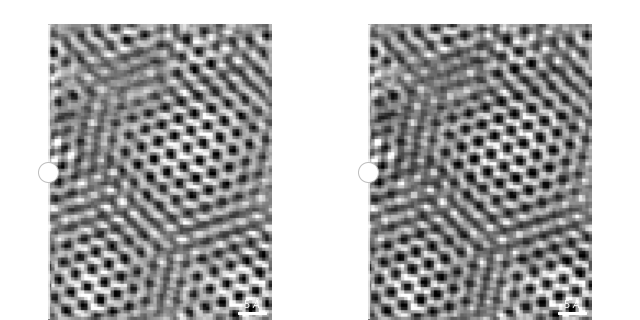

In [4]:
#| label: app:upsampled-example-MoS2
reconstructions = np.load("data/MoS2_reconstructions.npy")

with plt.ioff():
    dpi=72
    fig, axs = plt.subplots(1,2,figsize=(640/dpi,320/dpi),dpi=dpi)
fig.subplots_adjust(left=0, right=1, top=0.925, bottom=0,wspace=0)
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = False
fig.canvas.resizable = False
fig.canvas.layout.width = '600px'

sliders = add_individual_reveal_sliders(
    fig, axs,
    reconstructions,
    pixelsizes=(0.59/2,0.59/2),
    titles=["parallax imaging reconstruction","direct ptychography reconstruction"],
    init=0.0
)
fig.patch.set_alpha(0)
fig.canvas